<a href="https://colab.research.google.com/github/caseyh4/CA4015/blob/main/CA4015_19438512_Harry_Casey_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CA4015 Recommender System**


Link to git 

**Introduction**

For this assignment I am going to attempt to build a recommender system based on music artists from the [Last.fm](https://grouplens.org/datasets/hetrec-2011/) dataset. Recommender systems use machine learning algorithms to segment users based on the data it has about the user and the user's behavioral patterns and target them with suggestions which they might like. There are many popular services currently using recommender systems, for example Spotify which recommends music, Netlfix which recommends movies and shows and Amazon which recommends retail products. The purpose of a recommender systems is to predict the items that would interest the user.

**Content Based Filtering**

One approach to building a recommender system is content based filtering. This approach makes a recommendation based on the previous actions of a user or the feedback given by a user. It gives a suggestion to a user which the user usually likes for example recommending a horror movies as the user has watched many horror movies before. This model doesn't need any information about other users as it makes a recommendation that is specific to that user.


**Collaborative Filtering**

Another approach to building a recommender system is collaborative filtering. This method uses similarities between users and items simultaneously to provide recommendations. This approach bases its recommendation on the users opinions and can recommend an item to one user based on the interests of a different user that has similar interests.



**Data Cleaning**

I will now read in each of the files and perform some analysis on the data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os
import collections
import tensorflow.compat.v1 as tf
from sklearn.model_selection import train_test_split
from IPython import display

In [ ]:
artists = pd.read_csv('../content/artists.dat', sep='\t', encoding='latin-1')
tags = pd.read_csv('../content/tags.dat', sep='\t', encoding='latin-1')
user_artists = pd.read_csv('../content/user_artists.dat', sep='\t', encoding='latin-1')
user_friends = pd.read_csv('../content/user_friends.dat', sep='\t', encoding='latin-1')
user_tagged_artists_timestamps = pd.read_csv('../content/user_taggedartists-timestamps.dat', sep='\t', encoding='latin-1')
user_tagged_artists = pd.read_csv('../content/user_taggedartists.dat', sep='\t', encoding='latin-1')

In [ ]:
artists

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...
...,...,...,...,...
17627,18741,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...


In [ ]:
tags

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
...,...,...
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire


In [ ]:
user_artists

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [ ]:
number_of_users = len(user_artists.userID.unique())
number_of_users

1892

There are 1892 users

In [ ]:
user_friends.head()

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831


In [ ]:
user_tagged_artists_timestamps.head()

,userID,artistID,tagID,timestamp
0,2,52,13,1238536800000
1,2,52,15,1238536800000
2,2,52,18,1238536800000
3,2,52,21,1238536800000
4,2,52,41,1238536800000


In [ ]:
user_tagged_artists.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


I will now check for any misssing values in each of the files.

In [ ]:
for col in artists.columns:
    print(f' In the {col} column it is {artists[col].isnull().values.any()} that data is missing')

 In the id column it is False that data is missing
 In the name column it is False that data is missing
 In the url column it is False that data is missing
 In the pictureURL column it is True that data is missing


In [ ]:
for col in tags.columns:
    print(f' In the {col} column it is {tags[col].isnull().values.any()} that data is missing')

 In the tagID column it is False that data is missing
 In the tagValue column it is False that data is missing


In [ ]:
for col in user_artists.columns:
    print(f' In the {col} column it is {user_artists[col].isnull().values.any()} that data is missing')

 In the userID column it is False that data is missing
 In the artistID column it is False that data is missing
 In the weight column it is False that data is missing


In [ ]:
for col in user_friends.columns:
    print(f' In the {col} column it is {user_friends[col].isnull().values.any()} that data is missing')

 In the userID column it is False that data is missing
 In the friendID column it is False that data is missing


In [ ]:
for col in user_tagged_artists_timestamps.columns:
    print(f' In the {col} column it is {user_tagged_artists_timestamps[col].isnull().values.any()} that data is missing')

 In the userID column it is False that data is missing
 In the artistID column it is False that data is missing
 In the tagID column it is False that data is missing
 In the timestamp column it is False that data is missing


In [ ]:
for col in user_tagged_artists.columns:
    print(f' In the {col} column it is {user_tagged_artists[col].isnull().values.any()} that data is missing')

 In the userID column it is False that data is missing
 In the artistID column it is False that data is missing
 In the tagID column it is False that data is missing
 In the day column it is False that data is missing
 In the month column it is False that data is missing
 In the year column it is False that data is missing


The only file with missing data is in the artists file. This is only in the pictureURL column which will not have an impact on this project and there will be no need to impute these missing values.

There are 17632 artists but at the end rows of the id column you can see it goes up to 18745 so I must fix this.

In [ ]:
artists.tail()

,id,name,url,pictureURL
17627,18741,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...
17631,18745,Grzegorz Tomczak,http://www.last.fm/music/Grzegorz+Tomczak,http://userserve-ak.last.fm/serve/252/59486303...


In [ ]:
artist_id = pd.Series(artists.index.values,index=artists.id).to_dict()
artists.id = artists.id.map(artist_id) 

In [ ]:
artists.tail()

,id,name,url,pictureURL
17627,17627,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,17628,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,17629,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,17630,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...
17631,17631,Grzegorz Tomczak,http://www.last.fm/music/Grzegorz+Tomczak,http://userserve-ak.last.fm/serve/252/59486303...


I will delete the pictureURL as it will not be of any use to me.

In [ ]:
del artists['pictureURL']
artists

,id,name,url
0,0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER
1,1,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams
2,2,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest
3,3,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois
4,4,Bella Morte,http://www.last.fm/music/Bella+Morte
...,...,...,...
17627,17627,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s
17628,17628,Aya RL,http://www.last.fm/music/Aya+RL
17629,17629,Coptic Rain,http://www.last.fm/music/Coptic+Rain
17630,17630,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist


I will have to do the same as I did for artists as to the tags dataset.

In [ ]:
tags.tail()

,tagID,tagValue
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire
11945,12648,electro latino


In [ ]:
tag_id = pd.Series(tags.index.values,index=tags.tagID).to_dict()
tags.tagID = tags.tagID.map(tag_id)
tags.tail()

,tagID,tagValue
11941,11941,suomi
11942,11942,symbiosis
11943,11943,sverige
11944,11944,eire
11945,11945,electro latino


In [ ]:
user_artists

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


I must fix the IDs here different to how I did to the previous files before as values are repeated. 

In [ ]:
user_ids = pd.Series(range(0,user_artists.userID.nunique()),index=user_artists.userID.unique()).to_dict()
user_artists.userID = user_artists.userID.map(user_ids) 

user_artists.artistID = user_artists.artistID.map(artist_id) 
user_artists

,userID,artistID,weight
0,0,45,13883
1,0,46,11690
2,0,47,11351
3,0,48,10300
4,0,49,8983
...,...,...,...
92829,1891,17615,337
92830,1891,17616,297
92831,1891,17617,281
92832,1891,17618,280


Artist IDs are now replaced with the same values for the ids in artists.

In [ ]:
user_friends

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831
...,...,...
25429,2099,1801
25430,2099,2006
25431,2099,2016
25432,2100,586


I will now replace the ID values with the right ids from the user artists dataset.

In [ ]:
user_friends.friendID = user_friends.friendID.map(user_ids)
user_friends.userID = user_friends.userID.map(user_ids) 
user_friends 

,userID,friendID
0,0,257
1,0,400
2,0,482
3,0,709
4,0,772
...,...,...
25429,1890,1625
25430,1890,1807
25431,1890,1816
25432,1891,548


In [ ]:
user_tagged_artists

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010
186475,2100,16437,292,1,5,2010
186476,2100,16437,2087,1,7,2010
186477,2100,16437,2801,1,5,2010


In [ ]:
user_tagged_artists.artistID = user_tagged_artists.artistID.map(artist_id) 
user_tagged_artists.userID = user_tagged_artists.userID.map(user_ids) 
user_tagged_artists.tagID = user_tagged_artists.tagID.map(tag_id) 
user_tagged_artists

,userID,artistID,tagID,day,month,year
0,0,46.0,12,1,4,2009
1,0,46.0,14,1,4,2009
2,0,46.0,17,1,4,2009
3,0,46.0,20,1,4,2009
4,0,46.0,40,1,4,2009
...,...,...,...,...,...,...
186474,1891,15609.0,3,1,7,2010
186475,1891,15609.0,291,1,5,2010
186476,1891,15609.0,2047,1,7,2010
186477,1891,15609.0,2751,1,5,2010


**Analysis**

Now I will combine the artitsts data set with the user artists data set to see who is the most popular artitst.

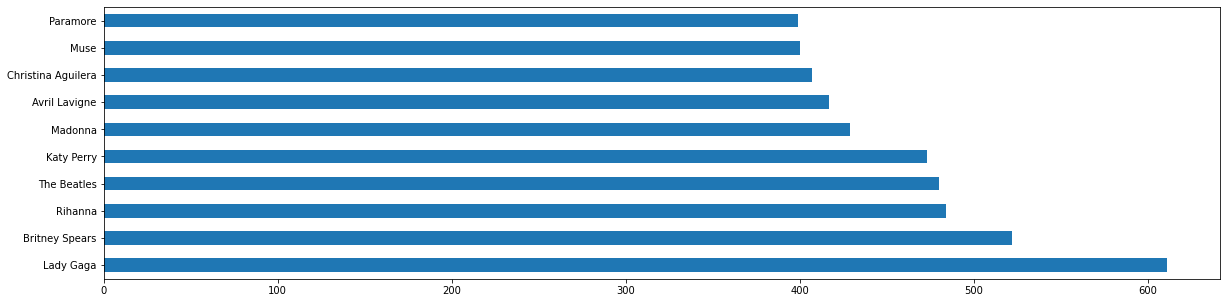

In [ ]:
plays = pd.merge(artists, user_artists, how="inner", left_on="id", right_on="artistID")
plays['name'].value_counts()[:10].plot(kind='barh', figsize=(20,5))

This is a count of listeners per artist and you can see Lady Gaga is the most popuar with nearly 100 unique listeners more than the second most popular artists Britney Spears.

In [ ]:
plays.describe()

,id,userID,artistID,weight
count,92834.000000,92834.000000,92834.000000,92834.00000
mean,3235.736724,944.222483,3235.736724,745.24393
std,4197.216910,546.751074,4197.216910,3751.32208
min,0.000000,0.000000,0.000000,1.00000
25%,430.000000,470.000000,430.000000,107.00000
50%,1237.000000,944.000000,1237.000000,260.00000
75%,4266.000000,1416.000000,4266.000000,614.00000
max,17631.000000,1891.000000,17631.000000,352698.00000


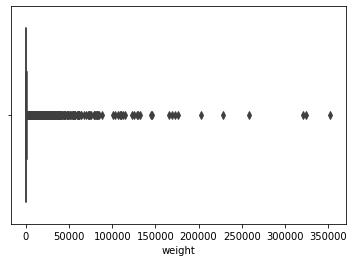

In [ ]:
sns.boxplot(x =plays.weight)
plt.show()

We can see here there are quite a lot of outliers here which may be errors in the data. There are users in the data that have listened to their artists far more than other users have.

Now I will look into see the most popular tags. You can see in the graph below that rock is the tag that feautures most in the data.

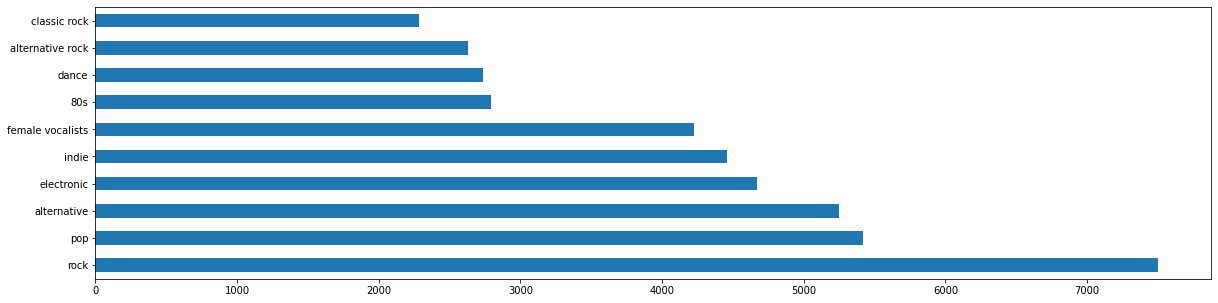

In [ ]:
tags = pd.merge(tags, user_tagged_artists, how="inner", left_on="tagID", right_on="tagID")
tags.isnull().values.any()
tags['tagValue'].value_counts()[:10].plot(kind='barh', figsize=(20,5))

**Building the model**


In [ ]:
usrs = np.array(plays['userID'])
max = plays['weight'].groupby(plays['userID']).max()
wghts = np.array(plays['weight'])
norm = []
for i in range(len(wghts)):
    index = usrs[i]
    normv = wghts[i] / max[index]
    norm.append(normv)

norm = np.array(norm)
plays['UserNorm'] = norm.tolist()


Here I have created a new column for a user based normalization where the column UserNorm is based off the users own max weight.

In [ ]:
plays

,id,name,url,userID,artistID,weight,UserNorm
0,0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,31,0,212,0.055775
1,0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,256,0,483,0.065394
2,0,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,729,0,76,0.025149
3,1,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,130,1,1021,0.150902
4,1,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,240,1,152,0.154315
...,...,...,...,...,...,...,...
92829,17627,Diamanda GalÃ¡s,http://www.last.fm/music/Diamanda+Gal%C3%A1s,423,17627,301,0.041386
92830,17628,Aya RL,http://www.last.fm/music/Aya+RL,423,17628,294,0.040423
92831,17629,Coptic Rain,http://www.last.fm/music/Coptic+Rain,423,17629,287,0.039461
92832,17630,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,423,17630,286,0.039324


I will use a sparse tensor function to build a sparse matrix for the model I am going to build. This will be efficient as each user will only listen to a small number of artists in comparison to the whole dataset of artists.

In [ ]:
def build_sparse_tensor(df):

    indices = df[['userID', 'artistID']].values
    values = df['UserNorm'].values
    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[len(plays.userID.unique()), len(plays.artistID.unique())])

To measure the approximation error I will build a function to measure the mean squared error.

In [ ]:
def sparse_mean_square_error(sparse_val, user_embeddings, artist_embeddings):
    predictions = tf.gather_nd(
        tf.matmul(user_embeddings, artist_embeddings, transpose_b=True),
        sparse_val.indices)
    loss = tf.losses.mean_squared_error(sparse_val.values, predictions)
    return loss

Below is a class to train a matrix factorization model.

In [ ]:
tf.disable_v2_behavior()
class CFModel(object):

  def __init__(self, embedding_vars, loss, metrics=None):

    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):

    return self._embeddings

  def train(self, num_iterations = 10, learning_rate = 1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):

    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        num_subplots = len(metrics) + 1
        fig = plt.figure()
        fig.set_size_inches(num_subplots * 10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i + 1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label = k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [ ]:
def split_dataframe(df, holdout_fraction=0.3):
  
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

In [ ]:
def build_model(data, embedding_dim=3, init_stddev=1.):

    train_data, test_data = split_dataframe(data)
    A_train = build_sparse_tensor(train_data)
    A_test = build_sparse_tensor(test_data)
    U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
    }
    embeddings = {
      "userID": U,
      "artistID": V
    }
    return CFModel(embeddings, train_loss, [metrics])

In [ ]:
modell = plays[['userID', 'artistID', 'UserNorm']]

Instructions for updating:
To construct input pipelines, use the `tf.data` module.


 iteration 1000: train_error=0.030888, test_error=0.677976

[{'train_error': 0.030888366, 'test_error': 0.67797583}]

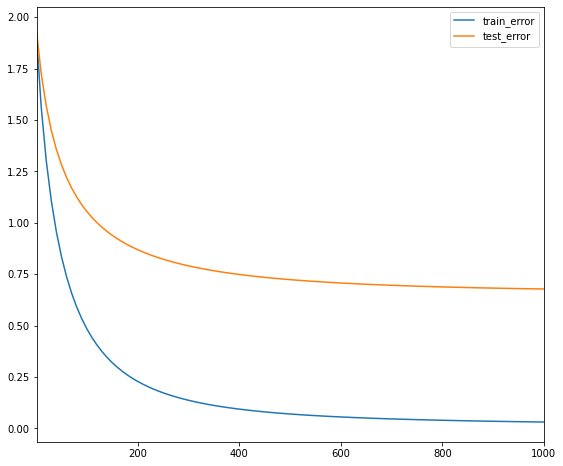

In [ ]:
model = build_model(modell,  embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

As you can see there is a drop in the training error.

**Inspecting the Embeddings**


Below are functions to compute scores and compare the two measures I am going to use which is dot product and cosine.

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

Below is a function to find the artists nearest neighbours.

In [ ]:
def artist_neighbors(model, substring, measure=DOT, k=6):
  ids =  artists[artists['name'].str.contains(substring)].index.values
  artistss = artists.iloc[ids]['name'].values
  if len(artistss) == 0:
    raise ValueError("Found no artist with title %s" % substring)
  print("Nearest neighbors of : %s." % artistss[0])
  if len(artistss) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(artistss[1:])))
  artistID = ids[0]
  scores = compute_scores(
      model.embeddings["artistID"][artistID], model.embeddings["artistID"],
      measure)
  score_key = measure + ' score'
  dataframe = pd.DataFrame({
      score_key: list(scores),
      'names': artists['name'],
  })
  display.display(dataframe.sort_values([score_key], ascending=False).head(k))

In [ ]:
artist_neighbors(model, 'Rihanna', DOT)
artist_neighbors(model, 'Rihanna', COSINE)

Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,dot score,names
6001,0.770057,Helmet
7382,0.665246,Cultura ProfÃ©tica
8706,0.637062,The Wonder Years
3230,0.624573,Fabrizio De AndrÃ©
5178,0.614054,Rare Bird
10473,0.598945,Dark Angel


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,cosine score,names
282,1.000000,Rihanna
294,0.763479,Katy Perry
460,0.718471,Ke$ha
6001,0.669164,Helmet
300,0.668003,Black Eyed Peas
283,0.648660,Britney Spears


In [ ]:
artist_neighbors(model, 'U2', DOT)
artist_neighbors(model, 'U2', COSINE)

Nearest neighbors of : U2.
[Found more than one matching artist. Other candidates: U2 and Green Day, Coldplay/U2]


,dot score,names
7119,1.048184,Annie Stela
11331,1.014042,D:Ream
715,1.011056,Wim Mertens
15736,0.994327,Illusion of Light
14904,0.991447,Nicoletta
9475,0.976454,Judy Collins


Nearest neighbors of : U2.
[Found more than one matching artist. Other candidates: U2 and Green Day, Coldplay/U2]


,cosine score,names
505,1.000000,U2
1686,0.645572,Susan Egan/Vaneese Thomas/Cheryl Freeman/LaCha...
11331,0.618070,D:Ream
715,0.610024,Wim Mertens
2776,0.607785,Sweet
9909,0.594883,Severed Heads


In [ ]:
artist_neighbors(model, 'Bruno Mars', DOT)
artist_neighbors(model, 'Bruno Mars', COSINE)

Nearest neighbors of : Bruno Mars.


,dot score,names
15122,2.898280,Marcela Morelo
6565,2.515957,Angel X
10816,2.360261,Tyler Ward
14931,2.335739,Mohammad Reza Shajarian
8281,2.294232,The Black Box Revelation
10250,2.278735,MalpaÃ­s


Nearest neighbors of : Bruno Mars.


,cosine score,names
1033,1.000000,Bruno Mars
3776,0.606543,Ð§Ð¸Ð¶ Ð¸ Ð¡Ð¾
3471,0.595400,Bathory
934,0.591106,Nevermore
9091,0.588264,Ian McCulloch
15122,0.574373,Marcela Morelo


**Regularization**

Now I will build a regularized Matrix Factorization model and train in to compare results.

In [ ]:
def gravity(U, V):
  return 1. / (U.shape[0].value * V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a = True) * tf.matmul(V, V, transpose_a = True))

def build_regularized_model(data, embedding_dim = 3, regularization_coeff = .1, gravity_coeff = 1., init_stddev = 0.1):

  train_ratings, test_ratings = split_dataframe(modell)
  A_train = build_sparse_tensor(train_ratings)
  A_test = build_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev = init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev = init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U * U) / U.shape[0].value + tf.reduce_sum(V * V) / V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"userID": U, "artistID": V}

  return CFModel(embeddings, total_loss, [losses, loss_components]), U, V

 iteration 2000: train_error_observed=0.032455, test_error_observed=0.051841, observed_loss=0.032455, regularization_loss=0.016935, gravity_loss=0.000742

[{'train_error_observed': 0.032455474, 'test_error_observed': 0.051841415},
 {'observed_loss': 0.032455474,
  'regularization_loss': 0.016934583,
  'gravity_loss': 0.0007419084}]

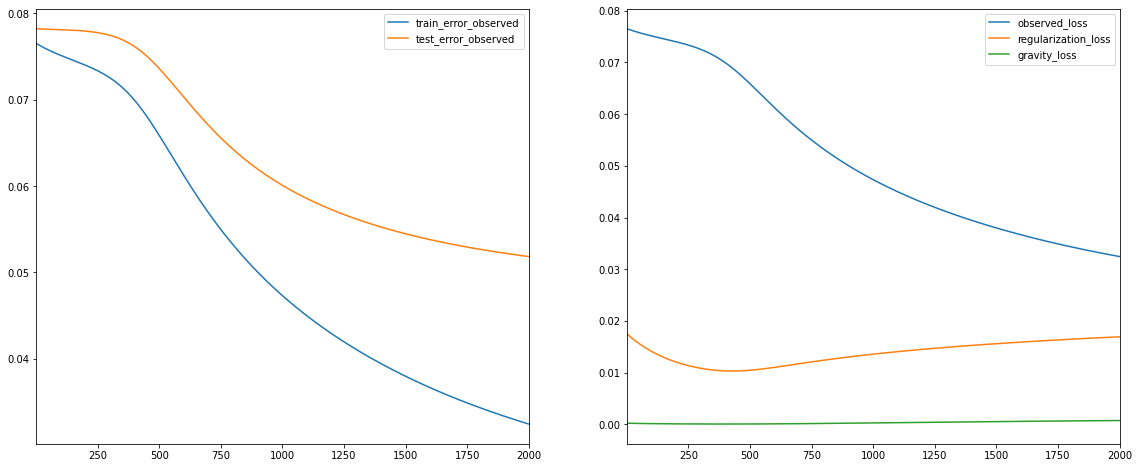

In [ ]:
reg_model, u, v  = build_regularized_model(modell, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35, init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

In [ ]:
artist_neighbors(reg_model, 'Rihanna', DOT)
artist_neighbors(reg_model, 'Rihanna', COSINE)

Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,dot score,names
282,4.550401,Rihanna
283,3.169762,Britney Spears
83,2.424468,Lady Gaga
673,2.314228,Glee Cast
289,2.214836,BeyoncÃ©
460,1.847559,Ke$ha


Nearest neighbors of : Rihanna.
[Found more than one matching artist. Other candidates: Rihanna (feat. Drake), Jay-Z, Bono, The Edge & Rihanna, RihannaÌ, Sean Paul ft. Rihanna, Rihanna-remixado REnan, \Eminem f_ Rihanna]


,cosine score,names
282,1.000000,Rihanna
3282,0.817643,Diana Vickers
380,0.740245,Cascada
525,0.738731,Taio Cruz
517,0.719317,Lindsay Lohan
460,0.705991,Ke$ha


In [ ]:
artist_neighbors(reg_model, 'U2', DOT)
artist_neighbors(reg_model, 'U2', COSINE)

Nearest neighbors of : U2.
[Found more than one matching artist. Other candidates: U2 and Green Day, Coldplay/U2]


,dot score,names
66,2.419909,Depeche Mode
505,2.033463,U2
201,1.519910,Arctic Monkeys
184,1.393652,Muse
59,1.392824,Coldplay
492,1.271981,Paramore


Nearest neighbors of : U2.
[Found more than one matching artist. Other candidates: U2 and Green Day, Coldplay/U2]


,cosine score,names
505,1.000000,U2
533,0.755133,Gossip
5065,0.751374,8mm
3438,0.738652,Wolfmother
614,0.736480,Pulp
697,0.734706,The xx


In [ ]:
artist_neighbors(reg_model, 'Bruno Mars', DOT)
artist_neighbors(reg_model, 'Bruno Mars', COSINE)

Nearest neighbors of : Bruno Mars.


,dot score,names
283,1.082278,Britney Spears
66,0.636803,Depeche Mode
282,0.515863,Rihanna
286,0.470707,Christina Aguilera
455,0.468266,Miley Cyrus
294,0.459851,Katy Perry


Nearest neighbors of : Bruno Mars.


,cosine score,names
1033,1.000000,Bruno Mars
321,0.778279,Chris Brown
1921,0.774206,Jennifer Hudson
315,0.755570,Jonas Brothers
7188,0.746795,Jay Sean
300,0.745739,Black Eyed Peas


**Comparing Results**

I am happy with the recommendations this final model is outputting. The regularization model is a lot better than the standard model and is giving much better predictions. To be given recommendations of artists you simply replcae 'Artist Name' with the name of an artist you like below and it will give you recommendations similar to this artist.

In [ ]:
artist_neighbors(reg_model, 'Artist Name', DOT)
artist_neighbors(reg_model, 'Artist Name', COSINE)